# Learning Uncertainty Sets

In [ ]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

### Formulating the uncertainty set

We now formulate the uncertainty set slightly differently, where data and a loss function is passed as parameters instead of the uncertainty set parameters. The new parameters for the uncertainty set, $A$ and $b$, will be trained through differentiable optimization. 

Box uncertainty: $\{ u \mid\| Au + b \|_\infty \leq 1 \}$ 
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 

Ellipsoidal uncertainty: $\{u \mid \| Au + b \|_p \leq 1 \}$ 
- $p$ : integer, optional  
  * Order of the norm. Default 2.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


Budget uncertainty: 
1. train the box portion only: $\{u \mid \| Au + b \|_\infty \leq 1, \| u \|_1 \leq \rho_2\}$ 
2. train the 1-norm portion only: $\{u \mid \| u \|_\infty \leq \rho_1, \| Au + b \|_1 \leq 1\}$ 
- train_box: boolean, optional
  * If True, train the box portion only. Default True. 
- $\rho_1$ : float, optional
  * Box scaling. Default 1.0.
- $\rho_2$ : float, optional
  * 1-norm scaling. Default 1.0.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set.
  

### Formulating the loss function

The loss function passed into the uncertainty set must be a function that returns torch tensors with gradient information. The function must take in as inputs all the variables defined in the Robust Problem, as well as the data used to evaluate the loss. There may also be other inputs to the function, depending on the type of loss.  
An example of a violation loss is 
$$
\mathcal{L}(\mathcal{D}, x) = f(x)  + \frac{\lambda }{N}\sum_{i=1}^{N} g(d_i,x)_+,
$$
where $\mathcal{D}$ is the dataset, $\lambda$ is the weight on the violation loss, $N$ is the total number of datapoints in the dataset, and $d_i$ is sample $i$ of the dataset. 

### Training the uncertainty set

To train the uncertainty set, after setting up the robust problem, call `problem.train()`, with optional parameters to control whether to train only $\epsilon$ or both $A$ and $b$, the total number of iterations, the learning rate of the problem, the optimizer to use, and initial values for $A$ and $b$. 

The function will return a pandas DataFrame with information on the iterates, as well as the reformulated problem.


### Example 1: Linear Portfolio


Consider the simple portfolio problem where we want to select a portfolio of stocks that maximizes returns. The Robust Problem is formulated as
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -u^Tx \leq  \tau\\
&\mathbf{1}^Tx = 1, x \geq 0,
\end{array}
$$
where $u$ is the uncertain parameter. 

We train an ellipsoidal uncertainty set with $p = 2$, and consider the violation loss $\tau + \lambda(-u^Tx - \tau)$, where $\lambda = 1$ is the scaling for the sum of violations. 

In [2]:
# The violation loss function, in torch tensors
def violation_loss(t_soln, x_soln, data, lmbda=1):
    return t_soln + lmbda * torch.mean(
        torch.maximum(-data @ x_soln - t_soln, torch.tensor(0., requires_grad=True))), t_soln
# Generate data
def normal_returns(m, N):
    np.random.seed = 1
    R = np.vstack([np.random.normal(
        i*0.03, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())
def normal_returns1(m, N):
    np.random.seed = 1
    R = np.vstack([np.random.normal(
        i*0.05, np.sqrt((0.01**2+(i*0.035)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

In [60]:
# Problem size
num_stocks = 50
N = 400

# Formulate the data
d1 = normal_returns(num_stocks,int(N/2))
data = d1
# d2 = normal_returns1(num_stocks,int(2*N/3))
# data = np.concatenate((d1,d2))

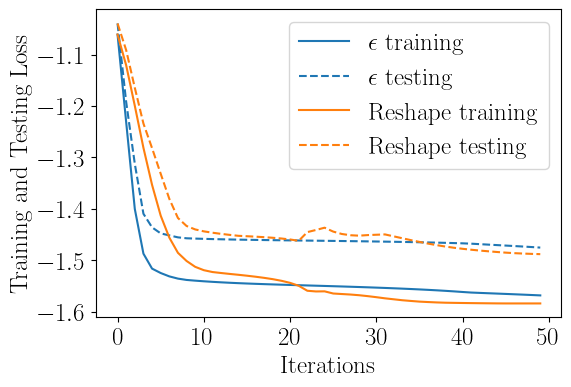

In [63]:

# Formulate the uncertainty set and uncertain parameter
unc_set = lro.Ellipsoidal(data=data, loss=violation_loss)
u = lro.UncertainParameter(num_stocks, uncertainty_set=unc_set)

# Formulate the Robust Problem
x = cp.Variable(num_stocks)
t = cp.Variable()

objective = cp.Minimize(t)
cons = [-u @ x <= t]
cons += [cp.sum(x) == 1, x >= 0]

prob_robust = lro.RobustProblem(objective, cons)
s = 10

# Train only epsilon
df, newprob = prob_robust.train(eps=True, lr=0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

# Train A and b
df1, newprob = prob_robust.train(lr=0.5, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

# Grid search epsilno
dfgrid, newprob = prob_robust.grid(epslst = np.linspace(0.3, 5, 20), seed = s)

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(df['step'], df['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
plt.plot(df['step'], df['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
plt.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
plt.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Training and Testing Loss")
plt.show()

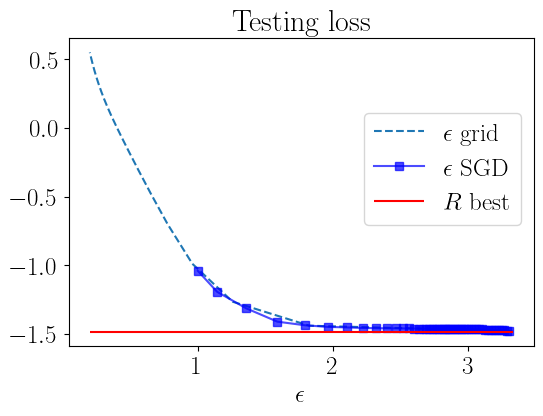

In [64]:
# Compare best values
plt.figure(figsize=(6, 4))
styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df["A_norm"],df["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
plt.xlabel("$\epsilon$")
plt.title("Testing loss")
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show()

### Example 2: Quadratic uncertainty
We consider a problem with quadratic uncertainty, 
$$g(u,x) = \sum_{i=1}^n g_i(u,x), \quad \text{where } \quad g_i(u,x) = -(1/2)u^T(P_ix_i)u.$$ 
We have each $P_i\in \mathbf{R}^{n\times n}$ a symmetric positive definite matrix, $u \in \mathbf{R}^n$ from an ellipsoidal set, and $x \in \mathbf{R}^{n}_{+}$. 
The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -(1/2)\sum_{i=1}^n (u^TP_iu)x_i  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& \mathbf{1}^Tx = 1\\
& x \geq 0, \quad x \leq 1,
\end{array}
$$
where $\theta$ encodes the training parameters $(A,b)$.

The reformulation is
\begin{equation}
	\begin{array}{lll}
		&\text{minimize} & f(x)\\
		&\text{subject to} & (1/2)\sum_{i=1}^n (z_i^TP_i^{-1}z_i)/x_i + b^Tz + \|\gamma\|_q \le 0\\
		&& A^T\gamma = z\\
		&& \sum_{i=1}^n z_i = z,\\
		&& \mathbf{1}^Tx = 1\\
		&& x \geq 0, \quad x \leq 1,
	\end{array}
\end{equation}
where we have $\gamma \in \mathbf{R}^m, z \in \mathbf{R}^n, z_i \in \mathbf{R}^n$, $i = 1,\dots,n$, as auxiliary variables. 

In [279]:
# Define the loss function
def loss(t,x,data,l = 2): 
    cur_sum = 0
    for i in range(data.shape[0]):
        cur_sum = cur_sum + torch.maximum(torch.sum(torch.tensor([-0.5*data[i]@torch.tensor(P[ind],requires_grad = True)
                                                                  *x[ind]@data[i] for ind in range(n)], requires_grad = True)) - t, 
                                          torch.tensor(0., requires_grad=True))
    return t + l*cur_sum/data.shape[0], t

def normal_returns_scaled(N, m, scale):
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())


def data_modes(N, m, scales):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = normal_returns_scaled(weights, m, scales[i])
    return d[0:N, :]
    
#Generate data
P = {}
P_inv = {}
n = 15
N = 100
for i in range(n):
    P[i] = datasets.make_spd_matrix(n, random_state=i)
    P_inv[i] = sc.linalg.sqrtm(np.linalg.inv(P[i]))
d1 = normal_returns(n,N)
data = data_modes(N,n,[1,2,5])
# d2 = normal_returns1(n,N)
# data = np.concatenate((d1,d2))

In [287]:
#Formulate the problem
s = 20
x = cp.Variable(n)
t = cp.Variable()
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data = data, 
                                                    loss = loss))
objective = cp.Minimize(t)
constraints = [cp.sum([-0.5*lro.uncertain_atoms.quad_form.quad_form(u, P[i]*x[i]) for i in range(n)]) <= t]
constraints += [cp.sum(x)==1]
constraints += [x >= 0, x <= 1]
# import ipdb
# ipdb.set_trace()
prob = lro.RobustProblem(objective, constraints)
df_eps, newprob = prob.train(eps = True, lr = 0.05, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

df1, newprob = prob.train(lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s)

df2, newprob = prob.train(lr = 0.05, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps = 1)


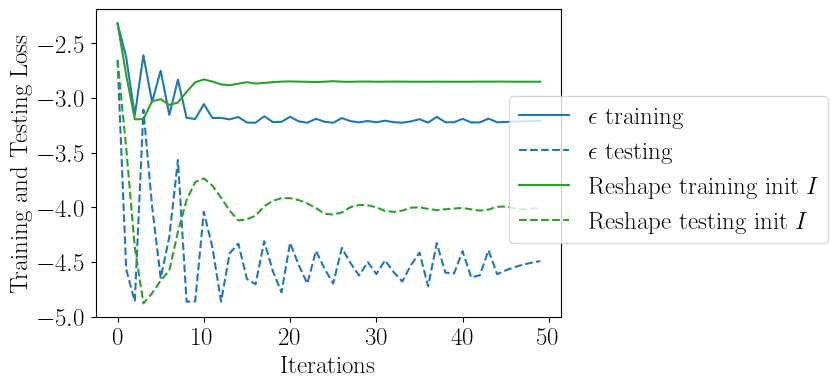

In [288]:
plt.figure(figsize=(6, 4))
plt.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
plt.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
# plt.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training init $\Sigma^{-1/2}$")
# plt.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing init $\Sigma^{-1/2}$")
plt.plot(df2['step'], df2['Loss_val'], color="tab:green", label="Reshape training init $I$")
plt.plot(df2['step'], df2['Eval_val'], linestyle='--', color="tab:green", label="Reshape testing init $I$")
plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0.2))
plt.xlabel("Iterations")
plt.ylabel("Training and Testing Loss")
plt.show()